In [14]:
from redplanet import utils

import pooch
import numpy as np

import os

In [15]:

__datapath = utils.getPath(pooch.os_cache('redplanet'), 'GRS')
'''
Path where pooch downloads/caches data.
'''







__nanval: float = -1e10
'''
Value given to pixels where data is not defined (i.e. "NOT_APPLICABLE_CONSTANT"). In the data, this is 9999.999.
We choose an extremely large negative value so we can easily filter/mask it when using the data or plotting. This errs on the side of caution.
'''

def get_nanval() -> float:
    return __nanval








__grid_spacing = 5 # degrees

__lat_range        = np.arange(-87.5 , 87.5   *1.0001, __grid_spacing)
__lat_range_ext    = np.arange(-92.5 , 92.5   *1.0001, __grid_spacing)

__lon_range        = np.arange(-177.5, 177.5  *1.0001, __grid_spacing)
__lon_range_ext    = np.arange(-182.5, 182.5  *1.0001, __grid_spacing)
'''
We opt to hardcode these values in the case of GRS because it's static. It's not hard to programmatically calculate these values in other cases -- the code for such is included but commented out below.
'''








__meta_dat: dict = {}
'''
`meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
    - `element_name` is from ['al','ca','cl','fe','h2o','k','si','s','th']
    - `quantity` is from:
        - 'concentration' = Concentration of the element. 
        - 'sigma' = The error associated with the concentration measurement. 

Calling `meta_dat` as such returns a 2D numpy array containing the original dataset where all units are in concentration out of one (i.e. original wt% * 0.01 or ppm * 0.000001). For some index [i,j], `i` is longitude from `__lon_range[0]` to `__lon_range[-1]`, and `j` is latitude from `__lat_range[0]` to `__lat_range[-1]`.
'''


"\n`meta_dat` is formatted as `meta_dat[element_name][quantity]`, where\n    - `element_name` is from ['al','ca','cl','fe','h2o','k','si','s','th']\n    - `quantity` is from:\n        - 'concentration' = Concentration of the element. \n        - 'sigma' = The error associated with the concentration measurement. \n\nCalling `meta_dat` as such returns a 2D numpy array containing the original dataset where all units are in concentration out of one (i.e. original wt% * 0.01 or ppm * 0.000001). For some index [i,j], `i` is longitude from `__lon_range[0]` to `__lon_range[-1]`, and `j` is latitude from `__lat_range[0]` to `__lat_range[-1]`.\n"

In [16]:
__lat_range

array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
       -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
         2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5])

In [3]:
"""
DESCRIPTION:
------------
    Download data (or load from cache) and format into usable dictionary `__meta_dat`.

REFERENCES:
------------
    2022_Mars_Odyssey_GRS_Element_Concentration_Maps:
        > Rani, A., Basu Sarbadhikari, A., Hood, D. R., Gasnault, O., Nambiar, S., & Karunatillake, S. (2022). 2001 Mars Odyssey Gamma Ray Spectrometer Element Concentration Maps. https://doi.org/https://doi.org/10.1029/2022GL099235
        - Data downloaded from https://digitalcommons.lsu.edu/geo_psl/1/
        - Data reuploaded to https://drive.google.com/file/d/1Z5Esv-Y4JAQvC84U-VataKJHIJ9OA4_8/view?usp=sharing for significantly increased downloading speeds

"""

'''load from pooch download/cache -- turn off the logger so we don't get unnecessary output every time a file is downloaded for the first time'''
logger = pooch.get_logger()
logger.disabled = True

filepaths = pooch.retrieve(
    fname='2022_Mars_Odyssey_GRS_Element_Concentration_Maps.zip',
    url=r'https://drive.google.com/file/d/1Z5Esv-Y4JAQvC84U-VataKJHIJ9OA4_8/view?usp=sharing',
    known_hash='sha256:45e047a645ae8d1bbd8e43062adab16a22786786ecb17d8e44bfc95f471ff9b7',
    path=__datapath,
    downloader=utils.download_gdrive_file,
    processor=pooch.Unzip(),
)

logger.disabled = False



for filepath in filepaths:

    filename = os.path.basename(filepath)
    if 'README' in filename: continue

    element_name = filename.split('_')[0].lower()


    '''initialize entry in `meta_dat`'''
    __meta_dat[element_name] = {}


    '''import data from files to np.ndarrays'''
    dat = np.loadtxt(filepath, skiprows=1)  
    dat = np.where(dat == 9999.999, get_nanval(), dat)


    """ ==> we hardcode these values because know the data is 5x5 degree grid
    lat_range = utils.unique(dat[:, 0])
    lon_range = utils.unique(dat[:, 1])

    if len(np.unique(np.diff(lon_range).round(decimals=3))) != 1:
        raise Exception('Longitude values are not evenly spaced. This is not supported by the interpolation model.')
    if len(np.unique(np.diff(lat_range).round(decimals=3))) != 1:
        raise Exception('Latitude values are not evenly spaced. This is not supported by the interpolation model.')

    '''edge case (part 1): longitude is cyclical, but data is not, so we duplicate one extra column on each edge of data & lon_range'''
    grid_spacing = np.unique(np.diff(lon_range).round(decimals=3))[0] # grid_spacing based on lon values, so it might be negative if lon is decreasing. but this is okay, it allows the lon cycling to work out.
    meta_dat[element_name]['grid spacing [degrees]'] = abs(grid_spacing)
    lon_range_cycled = np.array([lon_range[0]-grid_spacing, *lon_range, lon_range[-1]+grid_spacing]) # even if grid_spacing is negative, this will work out.
    """


    data_names = ['concentration', 'sigma']

    for i in range(len(data_names)):
        this_data = np.flip(dat[:, 2+i]) # make both latitudes and longitudes increasing
        
        '''reshape to 2D with [lat, lon] indexing'''
        this_data = this_data.reshape(__lat_range.shape[0], __lon_range.shape[0])

        '''units/corrections'''
        if element_name == 'th':
            correction=0.000001 # correct ppm to concentration out of 1
        else:
            correction=0.01 # correct weight percent to concentration out of 1
        this_data = np.where(this_data != get_nanval(), this_data*correction, this_data)


        '''edge case 1: lon is currently [-177.5, 177.5], but we want coverage up to [-180, 180]. Thus we pad each end with WRAPAROUND, leaving some extra space for bilinear interpolation to work.'''
        this_data = np.hstack([this_data[:, -1:], this_data, this_data[:, :1]])

        '''edge case 2: lat is currently [-87.5, 87.5], but we want coverage up to [-90, 90]. Thus we pad each end with DUPLICATION, leaving some extra space for bilinear interpolation to work.'''
        this_data = np.vstack([this_data[:1, :], this_data, this_data[-1:, :]])


        '''add to `meta_dat`'''
        __meta_dat[element_name][data_names[i]] = this_data





'''use this to pre-compute volatile concentration so we're accessing once instead of thrice. make appropriate changes in `get` as well. note that adding raw data into one grid and then doing bilinear interpolation is not different from doing bilinear interpolation individually and adding them up.'''
data_names = ['concentration', 'sigma']
__meta_dat['cl+h2o+s'] = {}

for data_name in data_names:
    __meta_dat['cl+h2o+s'][data_name] = __meta_dat['cl'][data_name] + __meta_dat['h2o'][data_name] + __meta_dat['s'][data_name]
    __meta_dat['cl+h2o+s'][data_name] = np.where(__meta_dat['cl+h2o+s'][data_name] < 0, get_nanval(), __meta_dat['cl+h2o+s'][data_name])

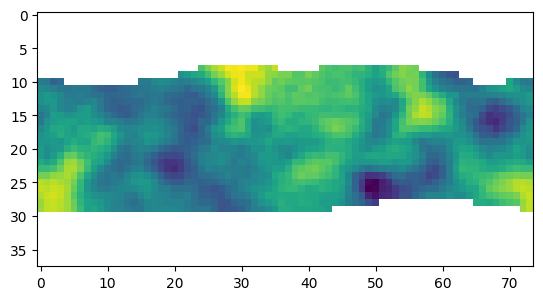

In [11]:
import matplotlib.pyplot as plt

dat = __meta_dat['th']['concentration']
dat = np.ma.masked_where((dat < 0), dat)
plt.imshow(dat[::-1])

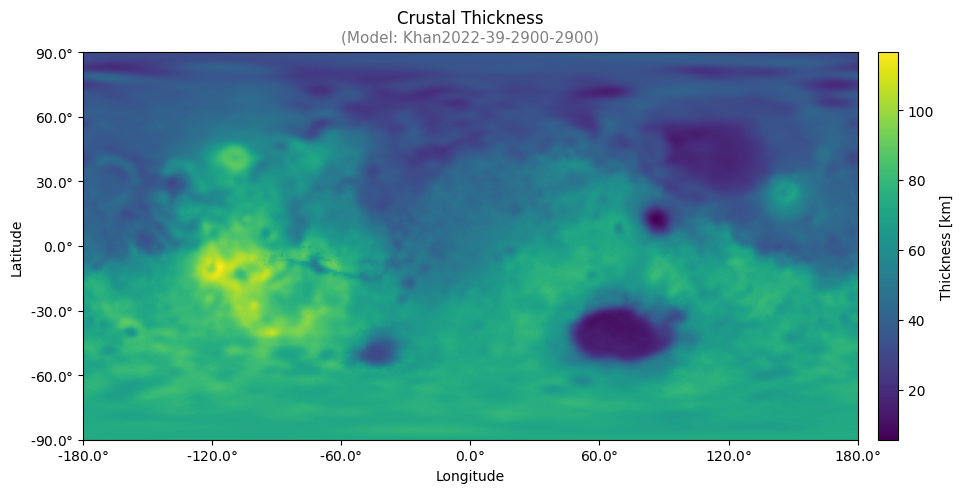

In [1]:
from redplanet import Crust
Crust.visualize('thick')

In [12]:
__lat_range

NameError: name '__lat_range' is not defined

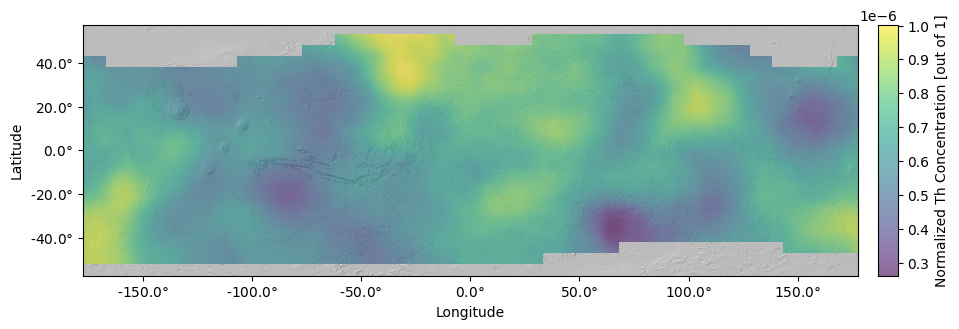

In [18]:
from redplanet import GRS
GRS.visualize('th', normalize=True, grid_spacing=1, overlay=True, lon_bounds=[-177.5, 177.5], lat_bounds=[-57.5, 57.5])